> pandas provides a flexible groupby interface, enabling you to slice, dice, and summarize datasets

# 10.1 GroupBy Mechanics

The term **split-apply-combine** is for describing group operations

In the first stage of the process, data contained in a pandas object, is split into groups based on one or more keys that you provide. The splitting is performed on a particular axis of an object

Once this is done, a function is applied to each group, producing a new value. Finally, the results of all those function applications are combined into a result object

See Figure 10-1 for a mockup of a simple group aggregation



<p align='center'>
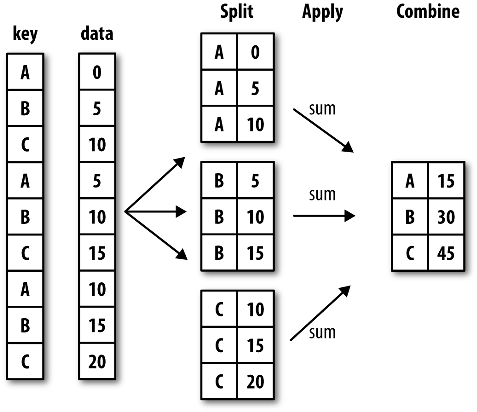
</p>
Figure 10-1. Illustration of a group aggregation

Each grouping key can take many forms, and **the keys do not have to be all of the same type:**

* A **list or array of values that is the same length as the axis being grouped**

* A **value indicating a column name** in a DataFrame

* A **dict or Series giving a correspondence between the values on the axis being grouped and the group names**

* A **function to be invoked on the axis index** or the individual labels in the index

Note that the latter three methods are shortcuts for producing an array of values to be used to split up the object

To get started, here is a small tabular dataset as a DataFrame:

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [4]:
df

,key1,key2,data1,data2
0,a,one,-1.072070,1.193486
1,a,two,1.149220,-0.753475
2,b,one,1.277581,-0.815067
3,b,two,-0.844121,1.879148
4,a,one,-0.044725,1.312953


Suppose you wanted to** compute the mean of the data1** column **using the labels from key1**

There are a number of ways to do this. One is to access data1 and call groupby with the column (a Series) at key1:

In [5]:
grouped = df['data1'].groupby(df['key1'])

In [6]:
grouped

This grouped variable is now a **GroupBy object.** **It has not actually computed anything yet** except for some intermediate data about the group key df['key1']

The idea is that **this object has all of the information needed to then apply some operation to each of the groups**

For example, to compute group means we can call the GroupBy’s mean method:



In [7]:
grouped.mean()

key1
a    0.010808
b    0.216730
Name: data1, dtype: float64

The important thing here is that the data **(a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the key1 column**

The result index has the name 'key1' because the DataFrame column df['key1'] did

If instead we had passed multiple arrays as a list, we’d get something different:

In [11]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [12]:
means

key1  key2
a     one    -0.558398
      two     1.149220
b     one     1.277581
      two    -0.844121
Name: data1, dtype: float64

Here **we grouped the data using two keys, and the resulting Series now has a hierarchical index **consisting of the unique pairs of keys observed:

In [14]:
means.unstack()

key2,one,two
key1,,
a,-0.558398,1.149220
b,1.277581,-0.844121


In this example, the group keys are all Series, though they could be any arrays of the right length:

In [15]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [16]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [17]:
df['data1'].groupby([states, years]).mean()

California  2005    1.149220
            2006    1.277581
Ohio        2005   -0.958096
            2006   -0.044725
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you want to work on

In that case, **you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:**

In [18]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.010808,0.584321
b,0.216730,0.532040


You may have noticed in the first case df.groupby('key1').mean() that there is no key2 column in the result

Because df['key2'] is not numeric data, it is said to be a nuisance column, which is therefore excluded from the result



In [20]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.558398  1.253220
     two   1.149220 -0.753475
b    one   1.277581 -0.815067
     two  -0.844121  1.879148

By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset

Regardless of the objective in using groupby, a generally useful GroupBy method is **size**, which **returns a Series containing group sizes:**

In [21]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

Take note that any **missing values in a group key will be excluded from the result**

## Iterating Over Groups

The **GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data.** Consider the following:

In [24]:
for name, group in df.groupby('key1'):
  print(name)
  print(group)

a
  key1 key2     data1     data2
0    a  one -1.072070  1.193486
1    a  two  1.149220 -0.753475
4    a  one -0.044725  1.312953
b
  key1 key2     data1     data2
2    b  one  1.277581 -0.815067
3    b  two -0.844121  1.879148


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [26]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
  print((k1, k2))
  print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -1.072070  1.193486
4    a  one -0.044725  1.312953
('a', 'two')
  key1 key2    data1     data2
1    a  two  1.14922 -0.753475
('b', 'one')
  key1 key2     data1     data2
2    b  one  1.277581 -0.815067
('b', 'two')
  key1 key2     data1     data2
3    b  two -0.844121  1.879148
